In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

from mov_av import moving_average

In [2]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

In [15]:
SZ = 'small'
PDT = 7 * 24  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 24  # batch size: any positive integer

DIST = PDT

In [4]:
def load_pretrained(context_length: int):
    moirai = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SZ}")
    # Prepare model
    pretrained_model = MoiraiForecast(
        module=moirai,
        prediction_length=PDT,
        context_length=context_length,
        patch_size=PSZ,
        num_samples=1000,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

    return pretrained_model

def get_model_data(model_folder: str, num_of_weeks: int, data: pd.DataFrame):
    
    if num_of_weeks*7*24 < 720:
        CTX = num_of_weeks*7*24  # context length: any positive integer
    else:
        CTX = 720
            
    if model_folder != "pretrained":
        model_folder = model_folder + str(num_of_weeks)
        model = os.listdir(model_folder)[0]
    
        model_path = os.path.join(model_folder, model)
    
        model = MoiraiForecast.load_from_checkpoint(
            prediction_length=PDT,
            context_length=CTX,
            patch_size=PSZ,
            num_samples=1000,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
            checkpoint_path=model_path
        )
    else:
        model = load_pretrained(CTX)

    ds = PandasDataset(data, target='Value', freq='H')

    # Split into train/test set
    train, test_template = split(
        ds, offset=-(data.shape[0] - num_of_weeks*(7*24))
    )  # assign last TEST time steps as test set

    NUM_WINDOWS = (data.shape[0] - num_of_weeks*(7*24)) // PDT

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # number of time steps for each prediction
        windows=NUM_WINDOWS,  # number of windows in rolling window evaluation
        distance=DIST, # number of time steps between each window - distance=PDT for non-overlapping windows
        max_history=CTX
    )

    return model, test_data, CTX

In [5]:
def get_model_perf(model: MoiraiForecast, test_data, step: int, metric: str = "MAE"):
    metrics = []        
    for perc in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
        if metric == "MAPE":
            eval_function = MAPE(perc)
        else:
            eval_function = MAE(perc)
        
        metric_eval = evaluate_model(
            model = model.create_predictor(batch_size=BSZ),
            test_data = test_data,
            metrics = [eval_function]
        )
    
        metrics.append(metric_eval)

    metrics = pd.concat(metrics, axis=1)
    metrics.index = pd.Series(f"Model_step_{step}")
    
    return metrics

def get_run_metrics(model_folder: str, data: pd.DataFrame, metric: str):
    models_perf = []
    for i in range(1, 27):
        try:
            num_of_weeks = i
            model, test_data, CTX = get_model_data(model_folder, num_of_weeks, data)
        
            model_metrics = get_model_perf(model, test_data=test_data, step=num_of_weeks, metric=metric)
            models_perf.append(model_metrics)
        except:
            pass

    return models_perf

In [6]:
data = it_data_23_24

model_folder = "outputs/finetune/moirai_small/1st_run/checkpoints/it_load_data_train_"
backtesting_with_refit = get_run_metrics(model_folder, data, "MAPE")

model_folder = "outputs/finetune/moirai_small/2nd_run/checkpoints/it_load_data_train_"
refit_1_pass =  get_run_metrics(model_folder, data, "MAPE")

model_folder = "outputs/finetune/moirai_small/3rd_run/checkpoints/it_load_data_train_"
refit_multiple_passes = get_run_metrics(model_folder, data, "MAPE")

model_folder = "pretrained"
pretrained = get_run_metrics(model_folder, data, "MAPE")

77it [00:01, 55.13it/s]
77it [00:00, 97.12it/s]
77it [00:00, 99.92it/s] 
77it [00:00, 98.90it/s]
77it [00:00, 98.53it/s]
77it [00:00, 97.89it/s]
76it [00:00, 95.11it/s]
76it [00:00, 96.18it/s]
76it [00:00, 98.00it/s]
76it [00:00, 96.56it/s]
76it [00:00, 98.06it/s]
76it [00:00, 96.65it/s]
75it [00:00, 94.08it/s]
75it [00:00, 93.97it/s]
75it [00:00, 95.81it/s]
75it [00:00, 94.69it/s]
75it [00:00, 96.03it/s]
75it [00:00, 94.72it/s]
74it [00:00, 90.98it/s]
74it [00:00, 90.96it/s]
74it [00:00, 90.82it/s]
74it [00:00, 90.35it/s]
74it [00:00, 90.98it/s]
74it [00:00, 91.11it/s]
73it [00:00, 89.92it/s]
73it [00:00, 91.10it/s]
73it [00:00, 92.51it/s]
73it [00:00, 91.14it/s]
73it [00:00, 92.05it/s]
73it [00:00, 90.96it/s]
72it [00:00, 92.36it/s]
72it [00:00, 93.49it/s]
72it [00:00, 94.79it/s]
72it [00:00, 93.48it/s]
72it [00:00, 94.91it/s]
72it [00:00, 93.52it/s]
71it [00:00, 93.79it/s]
71it [00:00, 92.84it/s]
71it [00:00, 92.16it/s]
71it [00:00, 93.27it/s]
71it [00:00, 91.75it/s]
71it [00:00, 93

In [7]:
backtesting_with_refit = pd.concat(backtesting_with_refit, axis=0)
refit_1_pass = pd.concat(refit_1_pass, axis=0)
refit_multiple_passes = pd.concat(refit_multiple_passes, axis=0)
pretrained = pd.concat(pretrained, axis=0)

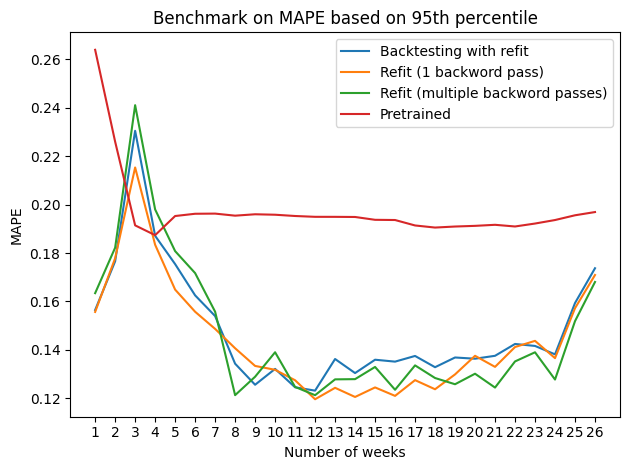

In [10]:
backtesting_with_refit['MAPE[0.95]'].plot(label='Backtesting with refit')
refit_1_pass['MAPE[0.95]'].plot(label='Refit (1 backword pass)')
refit_multiple_passes['MAPE[0.95]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.95]'].plot(label='Pretrained')
plt.xticks(range(0, 26), range(1, 27))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on 95th percentile')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_results/after_finetuning/mape_95th_perc.png");

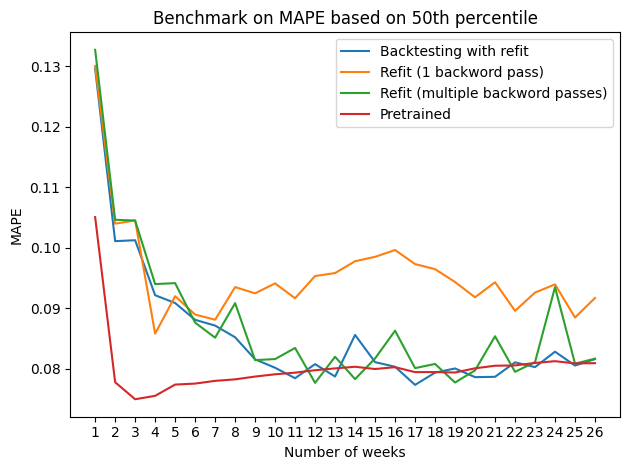

In [11]:
backtesting_with_refit['MAPE[0.5]'].plot(label='Backtesting with refit')
refit_1_pass['MAPE[0.5]'].plot(label='Refit (1 backword pass)')
refit_multiple_passes['MAPE[0.5]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.5]'].plot(label='Pretrained')
plt.xticks(range(0, 26), range(1, 27))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on 50th percentile')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_results/after_finetuning/mape_50th_perc.png");

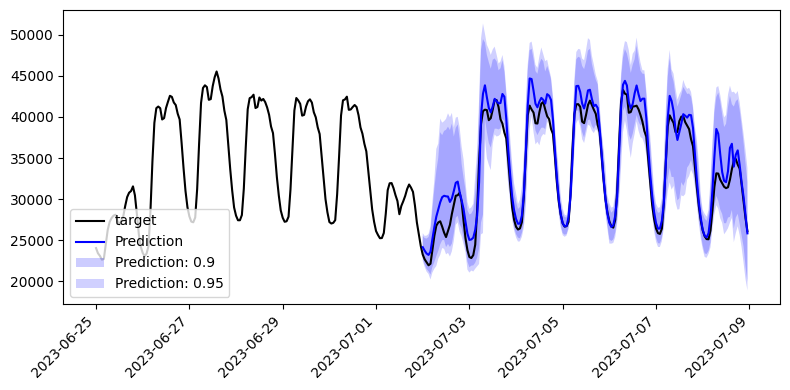

In [16]:
model_folder = "outputs/finetune/moirai_small/1st_run/checkpoints/it_load_data_train_"
data = it_data_23_24

model, test_data, CTX = get_model_data(model_folder, 26, data)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()

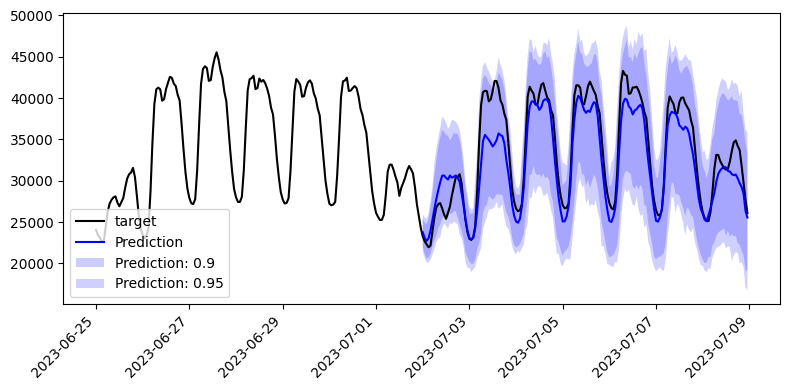

In [18]:
model = load_pretrained(720)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()